In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

## Read in and pre-process Data

In [32]:
# Load the dataframe from the csv file
file_name = "results/cellpose_scribbles_cluster_run02_240317100233.csv"
df = pd.read_csv(file_name)
df[:5]
# df.shape

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction
0,0,convpaint,all,0.010,a,101577,94519,18,9,9,196096,0.009179,0.560384,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
1,0,ilastik,all,0.010,a,101577,94519,18,9,9,196096,0.009179,0.915669,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
2,0,convpaint,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.936822,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3,0,ilastik,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.910727,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
4,0,convpaint,all,0.050,a,101577,94519,79,38,41,196096,0.040286,0.948031,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...


In [33]:
df_2 = df.copy()

In [44]:
# Add ilastik accuracy on the same row as convpaint accuracy as a new column ("acc. ilastik")
for scr in df_2['scribbles']:
    acc_il = df_2.loc[(df_2['scribbles'] == scr) & (df_2['prediction type'] == "ilastik"), "accuracy"].values[0]
    df_2.loc[(df_2['scribbles'] == scr) & (df_2['prediction type'] == "convpaint"), "acc. ilastik"] = acc_il

# Rename the "accuracy" column to "acc. convpaint"
df_2.rename(columns={"accuracy": "acc. convpaint"}, inplace=True)
# Add difference between convpaint and ilastik accuracy in a new column ("acc. diff")
df_2["acc. diff"] = df_2["acc. convpaint"] - df_2["acc. ilastik"]
# Move the columns
df_2 = df_2[["img_num", "scribbles mode", "scribbles bin", "suffix", "class_1_pix_gt", "class_2_pix_gt", "pix_labelled", "class_1_pix_labelled", "class_2_pix_labelled", "pix_in_img", "perc. labelled", "acc. convpaint", "acc. ilastik", "acc. diff", "image", "ground truth", "scribbles"]]
# Remove rows with NaN values (former rows with ilastik accuracy...)
df_2 = df_2.dropna()


In [57]:
df_2[df_2['scribbles bin'] > 0.01].sort_values(by="acc. diff", ascending=True)[:10]

,img_num,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,acc. convpaint,acc. ilastik,acc. diff,image,ground truth,scribbles
6306,450,all,0.100,a,28592,21758,45,25,20,50350,0.089374,0.446356,0.892512,-0.446157,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
6290,449,all,0.050,a,27146,23179,21,12,9,50325,0.041729,0.450174,0.855956,-0.405782,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
6050,432,all,0.025,a,34062,16285,9,6,3,50347,0.017876,0.340020,0.741156,-0.401136,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5814,415,all,0.050,a,27083,23163,20,11,9,50246,0.039804,0.461688,0.831111,-0.369422,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
6274,448,all,0.025,a,27514,22926,9,6,3,50440,0.017843,0.552557,0.882811,-0.330254,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5812,415,all,0.025,a,27083,23163,9,6,3,50246,0.017912,0.539068,0.866238,-0.327170,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5576,398,all,0.050,a,34337,42463,31,15,16,76800,0.040365,0.448802,0.764336,-0.315534,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
7492,535,all,0.025,a,116326,66970,37,23,14,183296,0.020186,0.656866,0.952236,-0.295369,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5128,366,all,0.050,a,30006,20240,23,14,9,50246,0.045775,0.410739,0.704136,-0.293396,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5580,398,all,0.250,a,34337,42463,173,76,97,76800,0.225260,0.536068,0.827695,-0.291628,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...


In [113]:
# Filter out some bins
df = df[df['scribbles bin'] != 0.01]
df = df[df['scribbles bin'] != 1]
# Change the values of the prediction types to be more readable
# df['prediction type'] = df['prediction type'].apply(lambda x: "convpaint" if x == "convpaintCh1" else "classic filters")
# Create two filtered dataframes
df['prediction type'] = df['prediction type'].apply(lambda x: "classic filters" if x == "ilastik" else x)
df_convpaint = df[df['prediction type'] == 'convpaint']
df_ilastik = df[df['prediction type'] == 'classic filters']
df[:5]

,img_num,prediction type,scribbles mode,scribbles bin,suffix,class_1_pix_gt,class_2_pix_gt,pix_labelled,class_1_pix_labelled,class_2_pix_labelled,pix_in_img,perc. labelled,accuracy,image,ground truth,scribbles,prediction
2,0,convpaint,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.936822,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
3,0,classic filters,all,0.025,a,101577,94519,40,22,18,196096,0.020398,0.910727,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
4,0,convpaint,all,0.050,a,101577,94519,79,38,41,196096,0.040286,0.948031,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
5,0,classic filters,all,0.050,a,101577,94519,79,38,41,196096,0.040286,0.922711,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...
6,0,convpaint,all,0.100,a,101577,94519,174,84,90,196096,0.088732,0.945180,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...,/home/rschwob/cellpose_scribbles_test/cellpose...


## Plot only one prediction type

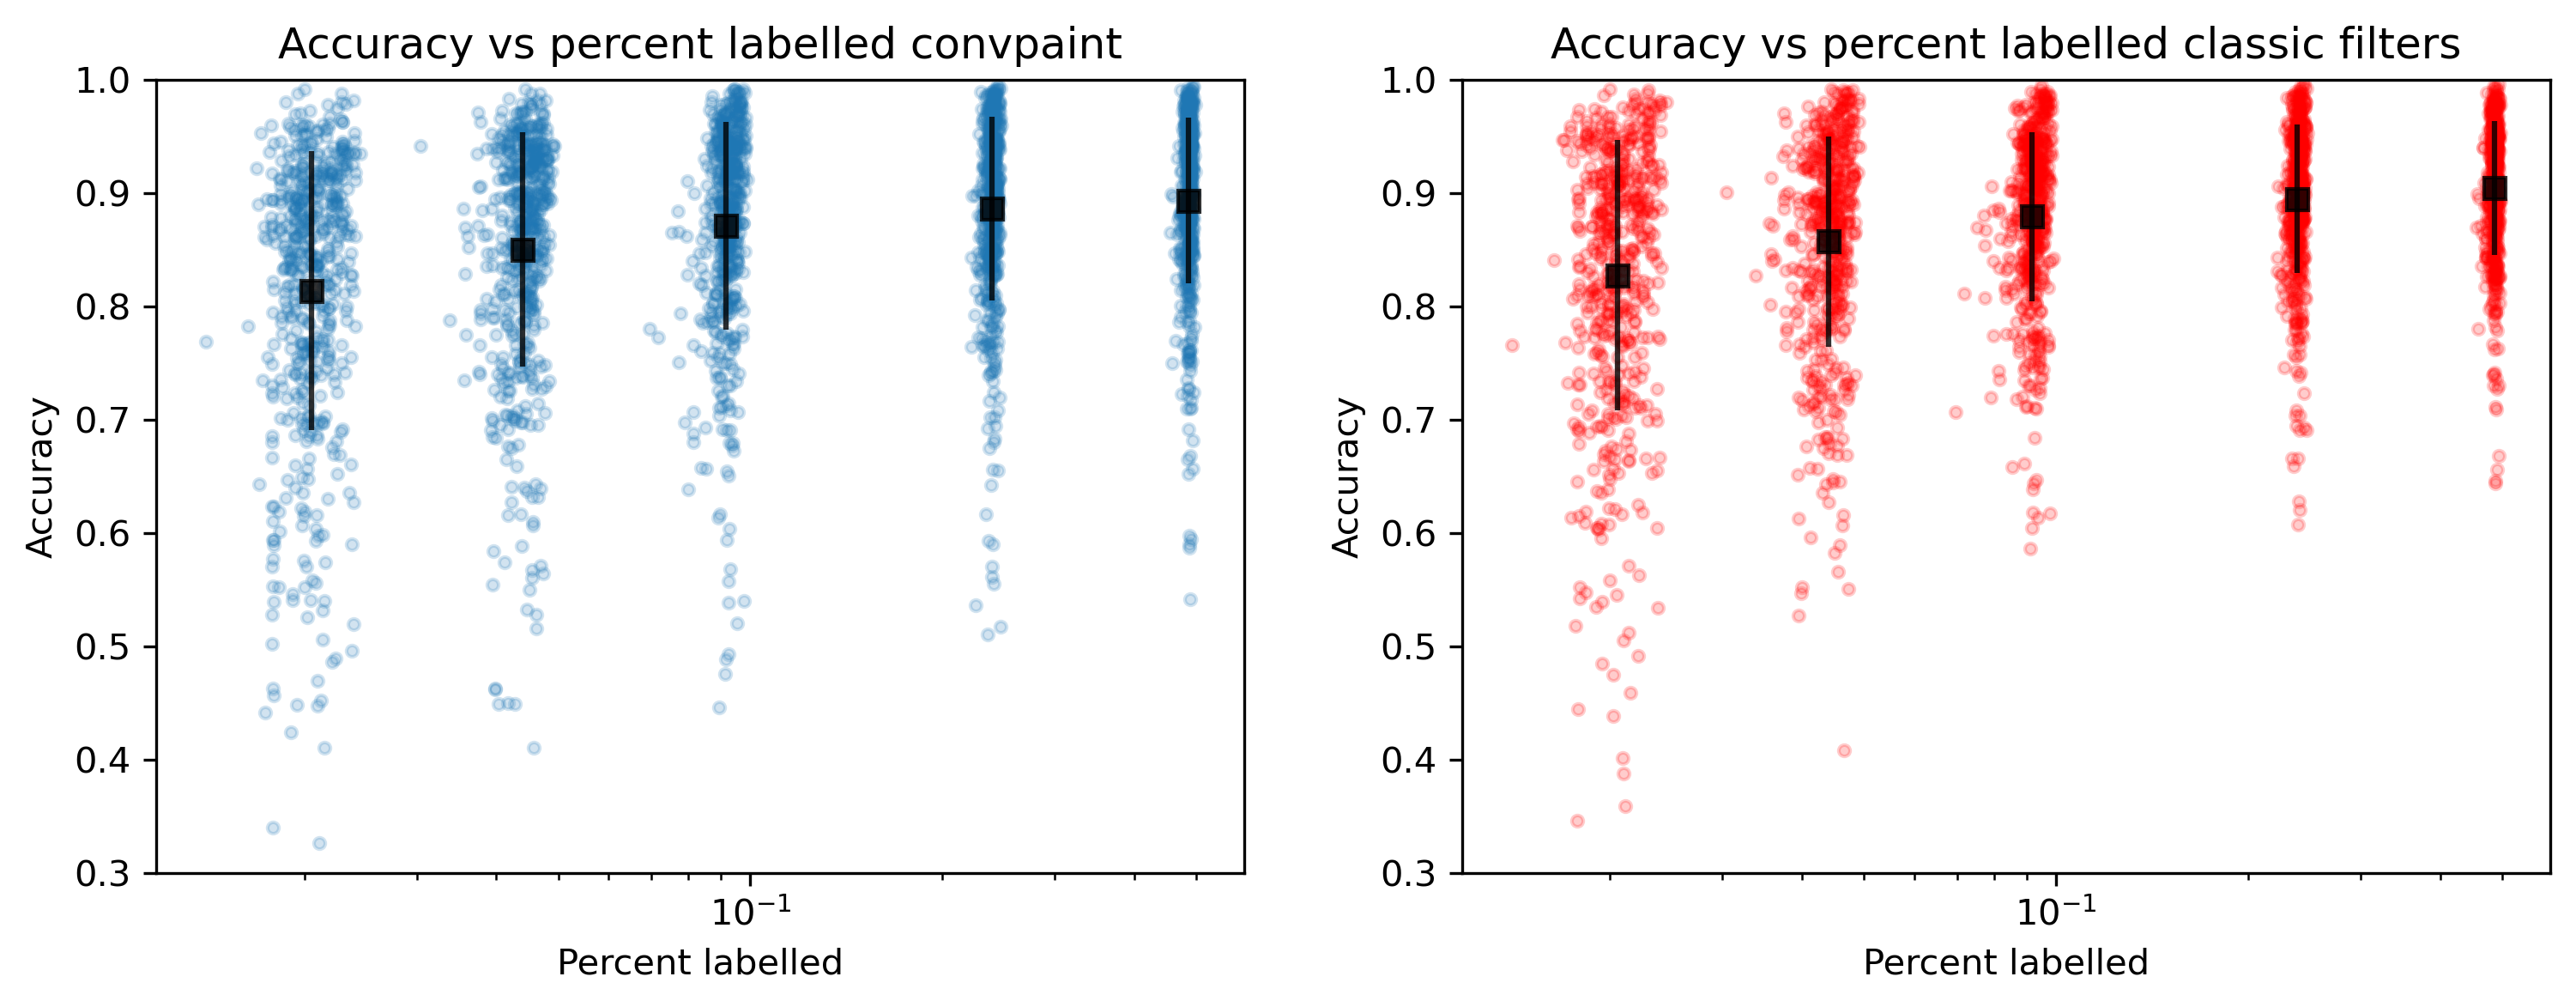

In [100]:
def plot_accuracy_vs_perc_labelled(df, pred_to_show, plt_ax=None, **kwargs):
    # Plot accuracy vs percent labelled
    df_filtered = df[df['prediction type'] == pred_to_show]

    # Scatterplot
    plt_ax.scatter(df_filtered['perc. labelled'], df_filtered['accuracy'], alpha=0.2, s=10, **kwargs)

    # Grouped plot
    df_grouped = df_filtered.groupby('scribbles bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
    plt_ax.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='black', alpha=0.8)
    plt_ax.set_xscale('log')
    plt_ax.set_ylim(0.3, 1)
    # plt_ax.set_xticks([0.05, 0.1, 1])
    plt_ax.set_xlabel('Percent labelled')
    plt_ax.set_ylabel('Accuracy')
    plt_ax.set_title(f'Accuracy vs percent labelled {pred_to_show}')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# set dpi
fig.set_dpi(300)
plot_accuracy_vs_perc_labelled(df, 'convpaint', plt_ax=ax[0])
plot_accuracy_vs_perc_labelled(df, 'classic filters', plt_ax=ax[1], c='red')
plt.show()


## Plot both prediction types together (convpaint vs. ilastik)

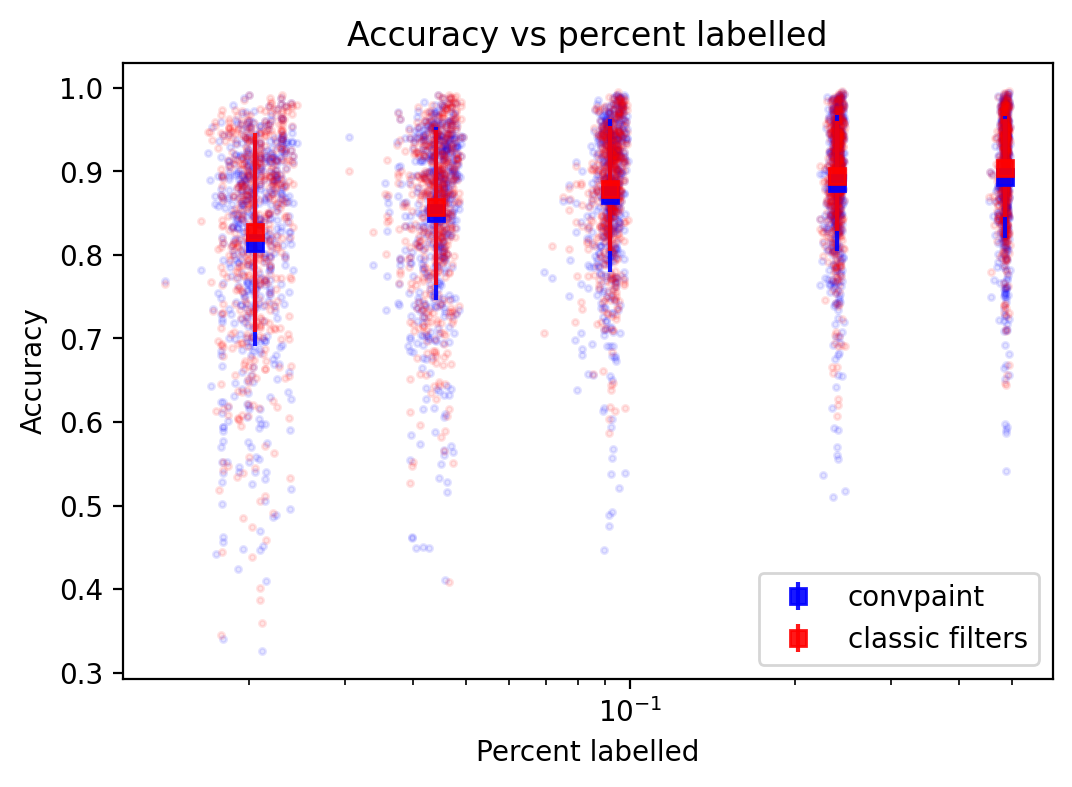

In [114]:
# Plot accuracy vs percent labelled
plt.figure(figsize=(6,4),dpi=200)

# ADD CONVPAINT PLOT
# Scatterplot
plt.scatter(df_convpaint['perc. labelled'], df_convpaint['accuracy'], alpha=0.1, s=5, c='blue')
# Grouped plot
df_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='blue', alpha=0.9, label='convpaint')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='blue', alpha=0.9)

# ADD ILASTIK PLOT
# Scatterplot
plt.scatter(df_ilastik['perc. labelled'], df_ilastik['accuracy'], alpha=0.1, s=5, c='red')
# Grouped plot
df_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': ['mean', 'std', 'median'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['mean'], yerr=df_grouped['accuracy']['std'], fmt='s', c='red', alpha=0.9, label='classic filters')
# plt.errorbar(df_grouped['perc. labelled']['mean'], df_grouped['accuracy']['median'], yerr=0, fmt='s', c='red', alpha=0.9)

# ADJUST PARAMETERS
plt.xscale('log')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.legend()
plt.show()

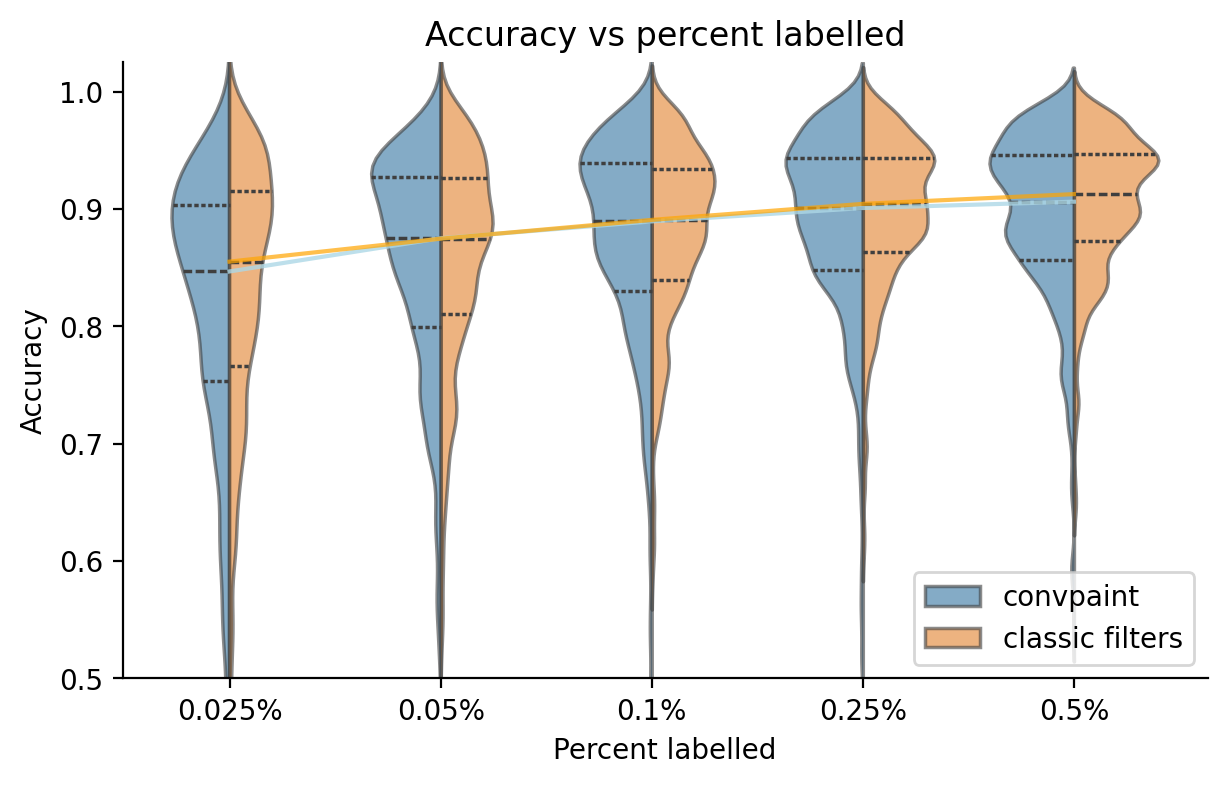

In [112]:
# Add a [0,0] point to the grouped dataframes manually
# df_convpaint_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_convpaint_grouped], ignore_index=True)
# df_ilastik_grouped = pd.concat([pd.DataFrame({'scribbles bin': [0], 'accuracy': [0]}), df_ilastik_grouped], ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'convpaint'}, ignore_index=True)
# df = df.append({'scribbles bin': 0, 'accuracy': 0, 'prediction type': 'classic filters'}, ignore_index=True)

plt.figure(figsize=(7, 4), dpi=200)

# Plot violin plot with seaborn split the violin between convpaint and ilastik
# Create the violin plot
ax = sns.violinplot(x='scribbles bin', y='accuracy', data=df, hue='prediction type', split=True, alpha=0.6, inner="quart", bw_adjust=0.65)

# Create line plot
# Group the bins
df_convpaint_grouped = df_convpaint.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
df_ilastik_grouped = df_ilastik.groupby('scribbles bin').agg({'accuracy': 'median'}).reset_index()
# Plot the means of each bin and connect them with a line
x_positions = ax.get_xticks()
plt.plot(x_positions, df_convpaint_grouped['accuracy'], color='lightblue', alpha=0.8)
plt.plot(x_positions, df_ilastik_grouped['accuracy'], color='orange', alpha=0.7)

# Set some parameters
x_labels = [f"{x}%" for x in df_convpaint_grouped['scribbles bin']]
plt.ylim(0.5, 1.025)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(x_positions, x_labels)
plt.legend(loc='lower right')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')

# Show or save the plot
plt.show()
# plt.savefig("convpaint-vs-ilastik_acc-vs-lab.svg", format='svg')